In [1]:
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from IPython.display import clear_output
from Scripts.metrics import ComputeMetrics
from tqdm import tqdm

## Load Data

### The CCS Concept Tree

In [2]:
labeled_concept_pair_df = pd.read_csv("Data/labeled_concept_pair_dataset.csv")
labeled_concept_pair_df.tail()

,kw1,kw2,label
25934,software testing debugging,combinational synthesis,0
25935,combinational synthesis,power management,0
25936,software fault tolerance,pcb design layout,0
25937,pcb design layout,formal method,0
25938,documentation,pcb design layout,0


### The articles preprocessed

In [3]:
articles_df = pd.read_csv("Data/data_processed.csv")

In [4]:
articles_df.tail()

,doi,abstract,ft_body,ccs,keywords,abstract_processed,ft_body_processed,kw_processed,main_concept_root,main_concept_leaf,high_Importance_concept_roots_and_leafs
107908,10.1145/2767134,<p>Online social media allow users to interact...,\n Detection of Political Manipulation in Onli...,{'CCS->Information systems->World Wide Web->We...,"['online social media', 'machine learning', 'o...",online social medium allow user interact one a...,detection political manipulation online commun...,"['online social medium', 'machine learning', '...",information system,web application,"[('information system', 'web application'), ('..."
107909,10.1145/2767135,<p>A classifier that determines if a webpage i...,\n Improving Researcher Homepage Classi.cation...,{'CCS->Information systems->Information retrie...,"['researcher homepage classification', 'co-tra...",classifier determines webpage relevant specifi...,improving researcher homepage classi cation un...,"['researcher homepage classification', 'co-tra...",information system,information retrieval,"[('information system', 'information retrieval')]"
107910,10.1145/2789211,<p>There has been a recent swell of interest i...,\n Diversionary Comments under Blog Posts JING...,{'Mathematics of computing~Bayesian networks':...,"['diversionary comments', 'classification', 'c...",recent swell interest analysis blog comment ho...,diversionary comment blog post jing wang cleme...,"['diversionary comment', 'classification', 'co...",mathematics computing,bayesian network,"[('mathematics computing', 'bayesian network')..."
107911,10.1145/2790304,<p>This work addresses the problem of estimati...,\n Estimating Clustering Coef.cients and Size ...,{'CCS->Theory of computation->Design and analy...,"['estimation', 'clustering coefficient', 'samp...",work address problem estimating social network...,estimating clustering coef cients size social ...,"['estimation', 'clustering coefficient', 'samp...",theory computation,design analysis algorithm,"[('theory computation', 'design analysis algor..."
107912,10.1145/2812812,<p>The Web 2.0 brought new requirements to the...,\n Fona: Quantitative Metric to Measure Focus ...,{'CCS->Hardware': 500},"['aria', 'focus navigation', 'web accessibility']",web 2 0 brought new requirement architecture w...,fona quantitative metric measure focus navigat...,"['aria', 'focus navigation', 'web accessibility']",NaN,NaN,"[(nan, nan)]"


In [5]:
### Get articles with bodies
articles_bodies_df = articles_df.dropna(subset=["ft_body_processed"])
articles_bodies_df.shape

(94692, 11)

The dimension of my embeddings will be $94,692$.

## Keyword Frequency and Ordering

### Get Unique Concepts

In [6]:
all_unique_kw = np.concatenate((np.array(labeled_concept_pair_df['kw1'].array), np.array(labeled_concept_pair_df['kw2'].array)))
all_unique_kw = list(set(all_unique_kw))
len(all_unique_kw)

1925

In [7]:
# from IPython.display import clear_output

# for i in range(0, 10000):
#     clear_output(wait=True)
#     print(i)

### Create Embeddings from Corpus

In [8]:
def ComputeKwDistribution(articles_series, kw, normalized = True):
    distrib = [0 for el in articles_series]

    for i, corpus in enumerate(articles_series):
        # distrib[i] = len(findAllIterationsInString(corpus, kw))
        distrib[i] = corpus.count(kw)
    # dist = articles_series.apply(lambda x: x.count(kw))
    
    distrib = np.array(distrib)

    return distrib/distrib.sum() if normalized and distrib.sum()!=0 else distrib

In [9]:
np.sum(ComputeKwDistribution(articles_bodies_df['ft_body_processed'], all_unique_kw[3], normalized = False))

213

In [10]:
## Creating the embedding dict:
embedding_dict = {}

for kw in tqdm(all_unique_kw):
    embedding_dict[kw] = ComputeKwDistribution(articles_bodies_df['ft_body_processed'], kw, normalized = False)

embedding_dict.values()[:10]

100%|██████████| 1925/1925 [33:53<00:00,  1.06s/it]


{'markov-chain monte carlo method': array([0, 0, 0, ..., 0, 0, 0]),
 'interest point salient region detection': array([0, 0, 0, ..., 0, 0, 0]),
 'multi-chip module': array([0, 0, 0, ..., 0, 0, 0]),
 'operation scheduling': array([0, 0, 0, ..., 0, 0, 0]),
 'multiple instruction single data': array([0, 0, 0, ..., 0, 0, 0]),
 'informal education': array([0, 0, 0, ..., 0, 0, 0]),
 'kernel density estimator': array([0, 0, 0, ..., 0, 0, 0]),
 'authentication': array([0, 0, 0, ..., 0, 0, 0]),
 'virtual reality': array([0, 0, 0, ..., 0, 0, 0]),
 'tablet computer': array([0, 0, 0, ..., 0, 0, 0]),
 'tree language': array([0, 0, 0, ..., 0, 0, 0]),
 'data recovery': array([0, 0, 0, ..., 0, 0, 0]),
 'regularization': array([0, 0, 0, ..., 0, 0, 0]),
 'semidefinite programming': array([0, 0, 0, ..., 0, 0, 0]),
 'topic modeling': array([0, 0, 0, ..., 3, 0, 0]),
 'approximate dynamic programming method': array([0, 0, 0, ..., 0, 0, 0]),
 'probabilistic reasoning': array([0, 0, 0, ..., 0, 0, 0]),
 'domai

#### Save the Embeddings

In [24]:
np.save('Data/ACM_concepts_embeddings.npy', embedding_dict)

#### Load the Saved Embeddings

In [3]:
embedding_dict = np.load('Data/ACM_concepts_embeddings.npy', allow_pickle=True).item()

#### Some Statistics on the Occurences of Concepts in Bodies

In [4]:
embedding_df = pd.DataFrame({"Concepts": embedding_dict.keys(), "Embeddings": embedding_dict.values()})
embedding_df.head()

,Concepts,Embeddings
0,markov-chain monte carlo method,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,interest point salient region detection,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,multi-chip module,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,operation scheduling,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,multiple instruction single data,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
Concepts_Not_Found = embedding_df[embedding_df.Embeddings.apply(sum) == 0]

In [6]:
print("Number of concepts not found in bodies:", len(Concepts_Not_Found))

Number of concepts not found in bodies: 116


In [7]:
Concepts_Not_Found.Concepts.array[:10]

<PandasArray>
[       'approximate dynamic programming method',
 'domain-specific security privacy architecture',
                         'speech / audio search',
                  'tactile hand-based interface',
  'publish-subscribe / event-based architecture',
              'world wide web network structure',
                       'fault model test metric',
              'application-specific vlsi design',
             'kalman filter hidden markov model',
         'analog mixed-signal circuit synthesis']
Length: 10, dtype: object

#### TF-IDF on Embeddings

In [17]:
def ConvertEmbeddingtoTFIDF(embed):
    num_docs = embed.shape[0]
    word_appearing_in = (embed != 0).sum()

    if word_appearing_in:
        tf    = np.log(1 + embed)
        idf   = np.log(num_docs/word_appearing_in)
        return tf * idf
    else:
        return embed

ConvertEmbeddingtoTFIDF(embedding_df.iloc[2, 1]).sum()

228.09692472120688

In [20]:
embedding_df["Embeddings_TFIDF"] = embedding_df["Embeddings"].apply(ConvertEmbeddingtoTFIDF)
embedding_df.tail()

,Concepts,Embeddings,Embeddings_TFIDF
1920,middle box / network appliance,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1921,soft intellectual property,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1922,business process monitoring,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1923,side-channel analysis countermeasure,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1924,n-tier architecture,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
embedding_df.index = embedding_df.Concepts

In [24]:
embedding_TFIDF_dict = embedding_df.to_dict()['Embeddings_TFIDF']

### Compute Information Theory Metrics

In [8]:
## Compute the metrics on both embeddings
temp_res = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: ComputeMetrics(x.kw1, x.kw2, embedding_dict), axis=1, result_type='expand'))
labeled_concept_pair_df[["H1", "H2", "DKL_1", "DKL_2", "ratio"]] = temp_res
labeled_concept_pair_df.tail()

,kw1,kw2,label,H1,H2,DKL_1,DKL_2,ratio
25934,software testing debugging,combinational synthesis,0,4.281174,-0.000000,1.0,1.0,1.0
25935,combinational synthesis,power management,0,-0.000000,6.359433,1.0,1.0,1.0
25936,software fault tolerance,pcb design layout,0,4.662347,-0.000000,1.0,1.0,1.0
25937,pcb design layout,formal method,0,-0.000000,7.343349,1.0,1.0,1.0
25938,documentation,pcb design layout,0,8.519688,-0.000000,1.0,1.0,1.0


In [9]:
labeled_concept_pair_df.describe()

,label,H1,H2,DKL_1,DKL_2,ratio
count,25939.000000,24451.000000,24501.000000,25939.000000,25939.000000,24450.000000
mean,0.001079,4.392556,4.390755,1.117004,1.130332,-143.494368
std,0.477659,2.336163,2.313780,1.041701,1.073786,4529.953227
min,-1.000000,-0.000000,-0.000000,-0.366204,-0.346574,-314998.436550
25%,0.000000,2.488641,2.486736,0.998854,0.998324,0.986629
50%,0.000000,4.500376,4.514765,1.000000,1.000000,1.000000
75%,0.000000,6.041638,6.014443,1.000000,1.000000,1.000000
max,1.000000,10.983814,10.983814,13.583852,13.296168,4116.890815


In [10]:
labeled_concept_pair_df = labeled_concept_pair_df.dropna(subset=['H1', 'H2', 'DKL_1', 'DKL_2', 'ratio'])
labeled_concept_pair_df.shape

(23098, 8)

## Gradient Boosting

#### Ternary Classification

In [23]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection  import cross_validate, GridSearchCV
from sklearn  import metrics   #Additional scklearn functions
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


processed_data = labeled_concept_pair_df.drop(columns=["kw1", "kw2"]).dropna(subset="ratio")

X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns="label"), processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [24]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [25]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.8602744473942519

In [26]:
best_model = gsearch1.best_estimator_

In [27]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [28]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


##### Performance analysis on test dataset

In [29]:
y_pred=best_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8773


Text(0, 0.5, 'Feature Importance Score')

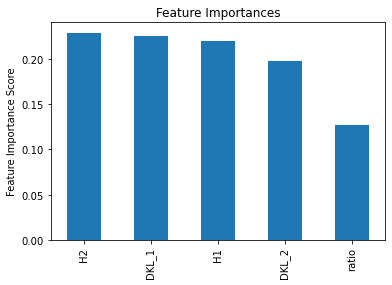

In [31]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

##### Plot confusion matrix:

<AxesSubplot:>

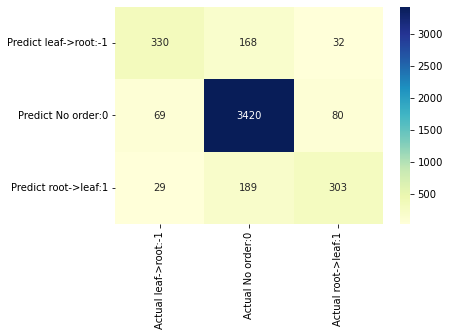

In [32]:
# visualize confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:-1', 'Actual No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:-1', 'Predict No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.62      0.69       530
           0       0.91      0.96      0.93      3569
           1       0.73      0.58      0.65       521

    accuracy                           0.88      4620
   macro avg       0.80      0.72      0.76      4620
weighted avg       0.87      0.88      0.87      4620



##### Save Models

In [34]:
pickle.dump(best_model, open("Models/GBM_Ternary_Classification.pkl", "wb"))

In [23]:
best_model = pickle.load(open("Models/naive_gridsearch.pkl", "rb"))
best_model

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=700, random_state=10, subsample=0.8)

#### Binary Classification, only on 0 and 1 labels

In [11]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection  import cross_validate, GridSearchCV
from sklearn  import metrics   #Additional scklearn functions
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


processed_data = labeled_concept_pair_df.drop(columns=["kw1", "kw2"]).dropna(subset="ratio")

processed_data['label'] = processed_data['label'].replace(-1, 0)## Replaces the -1 with zeros

X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns="label"), processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [12]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [13]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.9230781762935252

In [14]:
best_model = gsearch1.best_estimator_

In [15]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [16]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


##### Performance analysis on test dataset

In [17]:
y_pred=best_model.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [18]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9372


Text(0, 0.5, 'Feature Importance Score')

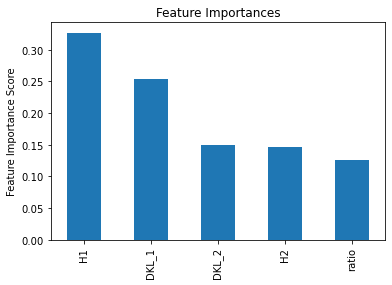

In [19]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

##### Plot confusion matrix:

<AxesSubplot:>

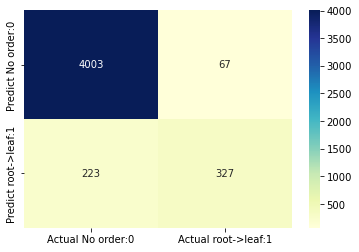

In [20]:
# visualize confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4070
           1       0.83      0.59      0.69       550

    accuracy                           0.94      4620
   macro avg       0.89      0.79      0.83      4620
weighted avg       0.93      0.94      0.93      4620



##### Save Models

In [22]:
pickle.dump(best_model, open("Models/GBM_Stats_Binary.pkl", "wb"))

## TF-IDF

### Compute Information Theory Metrics

In [26]:
## Compute the metrics on both embeddings
temp_res = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: ComputeMetrics(x.kw1, x.kw2, embedding_TFIDF_dict), axis=1, result_type='expand'))
labeled_concept_pair_df[["H1", "H2", "DKL_1", "DKL_2", "ratio"]] = temp_res
labeled_concept_pair_df.tail()

,kw1,kw2,label,H1,H2,DKL_1,DKL_2,ratio
25934,software testing debugging,combinational synthesis,0,4.364007e+00,-1.000089e-12,1.0,1.0,1.0
25935,combinational synthesis,power management,0,-1.000089e-12,7.019171e+00,1.0,1.0,1.0
25936,software fault tolerance,pcb design layout,0,5.067643e+00,-1.000089e-12,1.0,1.0,1.0
25937,pcb design layout,formal method,0,-1.000089e-12,7.886101e+00,1.0,1.0,1.0
25938,documentation,pcb design layout,0,9.070189e+00,-1.000089e-12,1.0,1.0,1.0


In [27]:
labeled_concept_pair_df.describe()

,label,H1,H2,DKL_1,DKL_2,ratio
count,25939.000000,2.445100e+04,2.450100e+04,25939.000000,25939.000000,24450.000000
mean,0.001079,4.682080e+00,4.679179e+00,1.094471,1.105889,-64.533618
std,0.477659,2.513748e+00,2.489406e+00,0.984097,1.015116,1542.501733
min,-1.000000,-1.000089e-12,-1.000089e-12,-0.367170,-0.355355,-91162.431239
25%,0.000000,2.692865e+00,2.698309e+00,0.995203,0.994344,0.985891
50%,0.000000,4.810482e+00,4.839052e+00,1.000000,1.000000,1.000000
75%,0.000000,6.450315e+00,6.449719e+00,1.000000,1.000000,1.000000
max,1.000000,1.139168e+01,1.139168e+01,12.335848,12.144929,1356.583222


In [28]:
labeled_concept_pair_df = labeled_concept_pair_df.dropna(subset=['H1', 'H2', 'DKL_1', 'DKL_2', 'ratio'])
labeled_concept_pair_df.shape

(23098, 8)

## Gradient Boosting

In [29]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection  import cross_validate, GridSearchCV
from sklearn  import metrics   #Additional scklearn functions
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


processed_data = labeled_concept_pair_df.drop(columns=["kw1", "kw2"]).dropna(subset="ratio")

X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns="label"), processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [31]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [32]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.8602716544273218

In [33]:
best_model = gsearch1.best_estimator_

In [34]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [35]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


##### Performance analysis on test dataset

In [36]:
y_pred=best_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8760


Text(0, 0.5, 'Feature Importance Score')

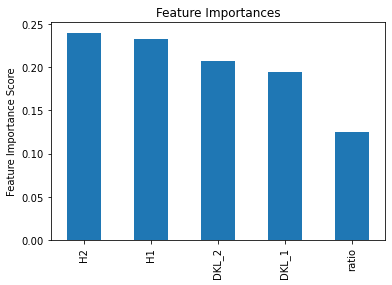

In [38]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

##### Plot confusion matrix:

<AxesSubplot:>

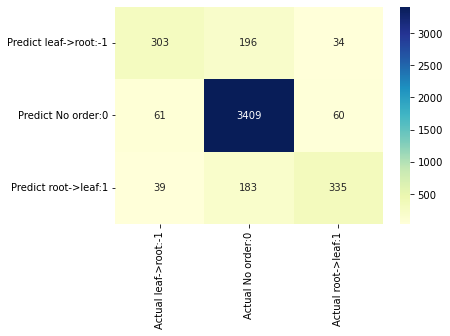

In [39]:
# visualize confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:-1', 'Actual No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:-1', 'Predict No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.75      0.57      0.65       533
           0       0.90      0.97      0.93      3530
           1       0.78      0.60      0.68       557

    accuracy                           0.88      4620
   macro avg       0.81      0.71      0.75      4620
weighted avg       0.87      0.88      0.87      4620



##### Save Models

In [41]:
pickle.dump(best_model, open("Models/naive_gridsearch_tfidf.pkl", "wb"))

In [42]:
best_model = pickle.load(open("Models/naive_gridsearch_tfidf.pkl", "rb"))
best_model

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=700, random_state=10, subsample=0.8)

## Dimension reduction techniques
Here we test regular dimension reduction techniques like PCA, SVD, NMS and MDS.

### PCA


## Embeddings and metrics

Here we test neural networks and there ability to generate 5D embeddings that helps the classification